# Setup

## Install packages

In [ ]:
!pip install git+https://github.com/cleanlab/cleanvision.git -qq
!pip install cleanlab -qq
!pip install scikeras -qq
!pip install -q --upgrade keras-cv
!pip install -U albumentations

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 104.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.8/347.8 kB 27.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 30.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 51.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.0/66.0 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 23.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 632.7/632.7 kB 42.7 MB/s eta 0:00:00
  Attempting uninstall: albucore
    Found existing installation: albucore 0.0.19
    Uninstalling albucore-0.0.19:
      Successfully uninst

## Import packages

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import json
import sys
import os
import keras_cv

#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

directory = "/content/"
user_data = directory + "training_data"
test_data = directory + "label_book/" # this can be the label book, or any other test set you create

In [ ]:
# Data centric AI
import cleanlab
from cleanvision.imagelab import Imagelab
from cleanlab.filter import find_label_issues
from scikeras.wrappers import KerasClassifier

# Tensorflow
from tensorflow.keras.utils import image_dataset_from_directory

# Sklearn
from sklearn.metrics import accuracy_score

# Common imports
from functools import partial
import pandas as pd
from PIL import Image

# To plot figures
import matplotlib.pyplot as plt

# Image augmentation
import albumentations as A

def plot_examples(id_iter, nrows=1, ncols=1):
    for count, id in enumerate(id_iter):
        plt.subplot(nrows, ncols, count + 1)
        plt.imshow(images[id].reshape(32, 32, 3), cmap="gray")
        original_label = reverse_label_mapping[labels[id]]
        predicted_label = reverse_label_mapping[predicted_labels[id]]
        plt.title(f"id: {id} \n original: {original_label}\n predicted: {predicted_label}")
        plt.axis("off")

    plt.tight_layout(h_pad=3.0)

## Download data

In [ ]:
!gdown --fuzzy https://drive.google.com/file/d/1-SpmUBB-Q-BdX8AYosU788KMOfr4ttgQ/view?usp=sharing # Replace the link with your file

Downloading...
From (original): https://drive.google.com/uc?id=1-SpmUBB-Q-BdX8AYosU788KMOfr4ttgQ
From (redirected): https://drive.google.com/uc?id=1-SpmUBB-Q-BdX8AYosU788KMOfr4ttgQ&confirm=t&uuid=3f18e812-708c-4f67-97b5-272803f910ff
To: /content/Final.zip
100% 11.9M/11.9M [00:00<00:00, 35.0MB/s]


In [ ]:
!unzip Final.zip

Archive:  Final.zip
   creating: training_data/
  inflating: training_data/desktop.ini  
   creating: label_book/
  inflating: label_book/.DS_Store    
   creating: label_book/x/
  inflating: label_book/x/.DS_Store  
  inflating: label_book/x/a9e4f63e-ce5d-11eb-b317-38f9d35ea60f.png  
  inflating: label_book/x/a97df060-ce5d-11eb-b317-38f9d35ea60f.png  
  inflating: label_book/x/a9b14348-ce5d-11eb-b317-38f9d35ea60f.png  
  inflating: label_book/x/a9a4255a-ce5d-11eb-b317-38f9d35ea60f.png  
  inflating: label_book/x/a9d6228a-ce5d-11eb-b317-38f9d35ea60f.png  
  inflating: label_book/x/desktop.ini  
   creating: label_book/vi/
  inflating: label_book/vi/.DS_Store  
  inflating: label_book/vi/a343231e-ce5d-11eb-b317-38f9d35ea60f.png  
  inflating: label_book/vi/a3095b98-ce5d-11eb-b317-38f9d35ea60f.png  
  inflating: label_book/vi/a2f8da20-ce5d-11eb-b317-38f9d35ea60f.png  
  inflating: label_book/vi/a2f7b186-ce5d-11eb-b317-38f9d35ea60f.png  
  inflating: label_book/vi/a35d6e72-ce5d-11eb-b317-

# CleanVision

Reading images from /content/training_data
Sample images from the dataset


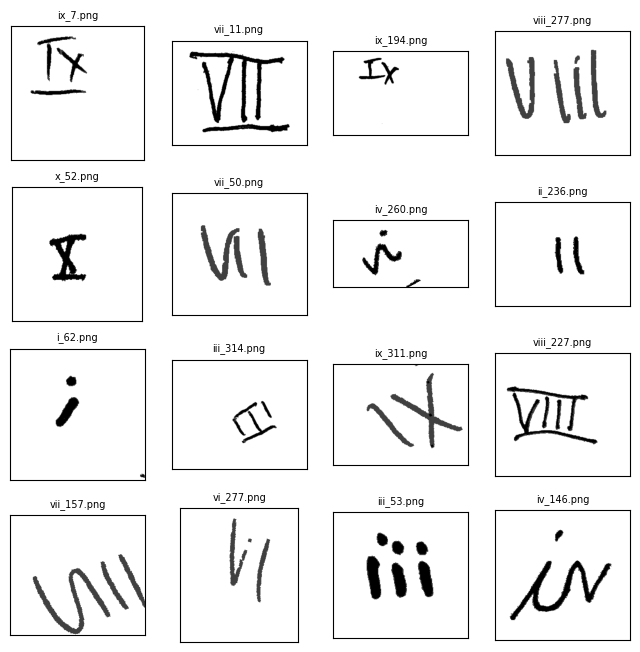

In [ ]:
# Path to the dataset
dataset_path = user_data

# Initialize imagelab
imagelab = Imagelab(data_path=dataset_path)

# Visualize a few sample images from the dataset
imagelab.visualize(num_images=16)

In [ ]:
# Find issues
imagelab.find_issues()

Checking for dark, light, odd_aspect_ratio, low_information, exact_duplicates, near_duplicates, blurry, grayscale, odd_size images ...


  0%|          | 0/4275 [00:00<?, ?it/s]

  0%|          | 0/4275 [00:00<?, ?it/s]

Issue checks completed. 9924 issues found in the dataset. To see a detailed report of issues found, use imagelab.report().


Issues found in images in order of severity in the dataset

|    | issue_type       |   num_images |
|---:|:-----------------|-------------:|
|  0 | low_information  |         4248 |
|  1 | grayscale        |         3742 |
|  2 | light            |         1669 |
|  3 | near_duplicates  |          114 |
|  4 | exact_duplicates |           98 |
|  5 | odd_size         |           53 |
|  6 | dark             |            0 |
|  7 | blurry           |            0 |
|  8 | odd_aspect_ratio |            0 | 

------------------ low_information images ------------------

Number of examples with this issue: 4248
Examples representing most severe instances of this issue:



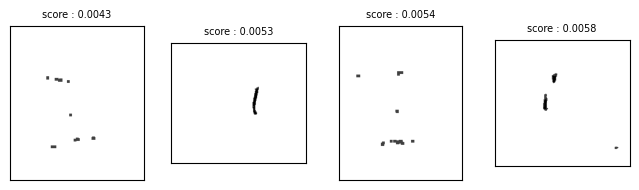

--------------------- grayscale images ---------------------

Number of examples with this issue: 3742
Examples representing most severe instances of this issue:



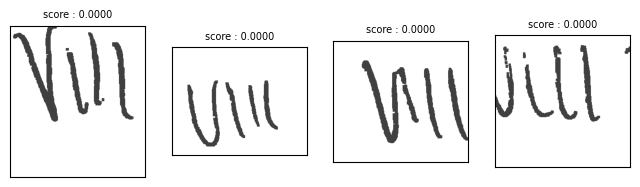

----------------------- light images -----------------------

Number of examples with this issue: 1669
Examples representing most severe instances of this issue:



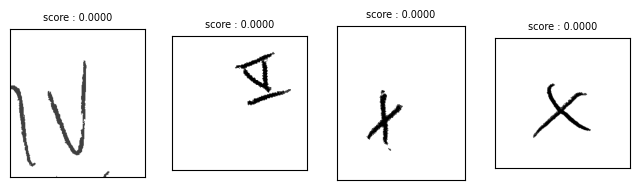

------------------ near_duplicates images ------------------

Number of examples with this issue: 114
Examples representing most severe instances of this issue:

Set: 0


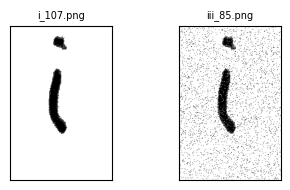

Set: 1


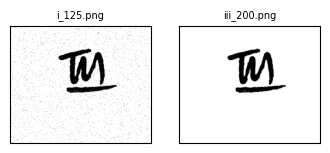

Set: 2


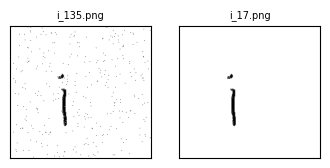

Set: 3


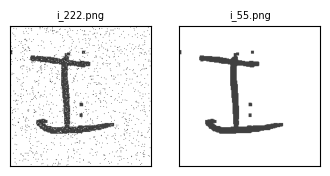

----------------- exact_duplicates images ------------------

Number of examples with this issue: 98
Examples representing most severe instances of this issue:

Set: 0


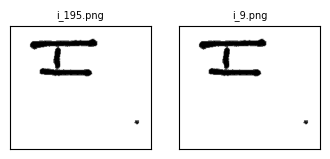

Set: 1


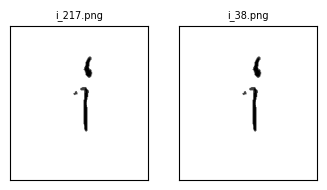

Set: 2


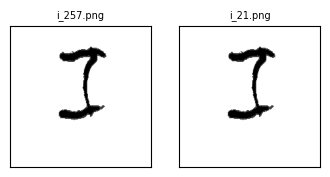

Set: 3


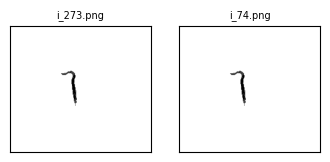

--------------------- odd_size images ----------------------

Number of examples with this issue: 53
Examples representing most severe instances of this issue:



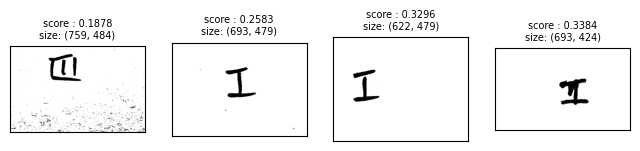

In [ ]:
imagelab.report(max_prevalence=1)

In [ ]:
imagelab.issues

,odd_size_score,is_odd_size_issue,odd_aspect_ratio_score,is_odd_aspect_ratio_issue,low_information_score,is_low_information_issue,light_score,is_light_issue,grayscale_score,is_grayscale_issue,dark_score,is_dark_issue,blurry_score,is_blurry_issue,exact_duplicates_score,is_exact_duplicates_issue,near_duplicates_score,is_near_duplicates_issue
/content/training_data/train/i/i_0.png,0.942688,False,0.954545,False,0.036344,True,0.74902,False,0,True,1.0,False,1.0,False,1.0,False,1.0,False
/content/training_data/train/i/i_1.png,0.968787,False,0.804348,False,0.032163,True,0.74902,False,0,True,1.0,False,1.0,False,1.0,False,1.0,False
/content/training_data/train/i/i_10.png,0.949864,False,0.979339,False,0.035782,True,0.74902,False,0,True,1.0,False,1.0,False,1.0,False,1.0,False
/content/training_data/train/i/i_100.png,0.770427,False,0.715026,False,0.024825,True,0.00000,True,0,True,1.0,False,1.0,False,1.0,False,1.0,False
/content/training_data/train/i/i_101.png,0.774662,False,1.000000,False,0.210710,True,0.74902,False,1,False,1.0,False,1.0,False,1.0,False,1.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
/content/training_data/val/x/x_91.png,0.841355,False,0.791328,False,0.013331,True,0.00000,True,0,True,1.0,False,1.0,False,1.0,False,1.0,False
/content/training_data/val/x/x_92.png,0.909003,False,0.983444,False,0.180183,True,0.00000,True,1,False,1.0,False,1.0,False,1.0,False,1.0,False
/content/training_data/val/x/x_93.png,0.972512,False,0.981818,False,0.030055,True,0.00000,True,0,True,1.0,False,1.0,False,1.0,False,1.0,False
/content/training_data/val/x/x_94.png,0.928971,False,1.000000,False,0.039561,True,0.74902,False,0,True,1.0,False,1.0,False,1.0,False,1.0,False


## near duplicates

In [ ]:
imagelab.info['near_duplicates']['num_sets']

57

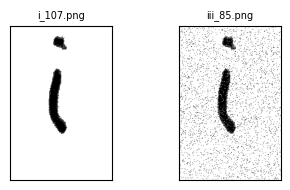

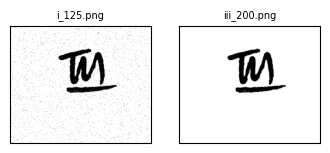

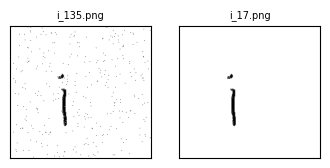

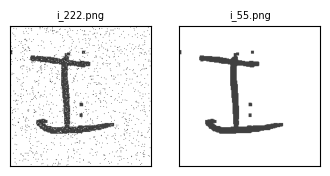

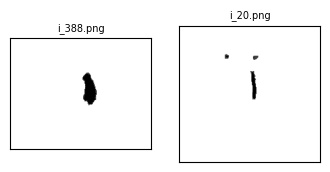

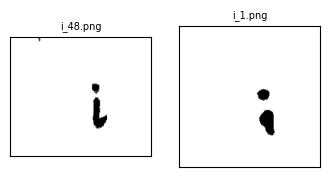

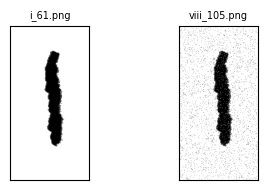

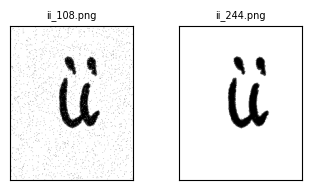

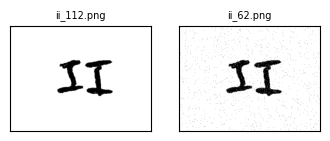

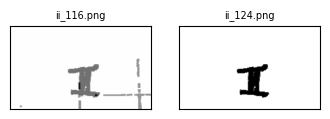

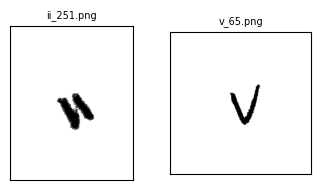

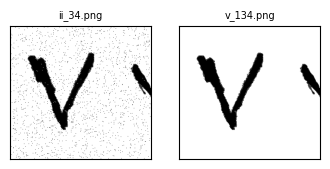

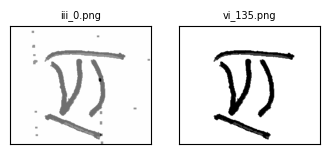

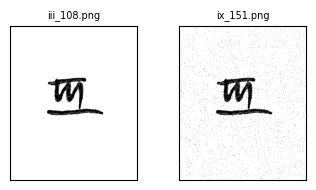

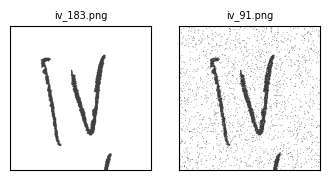

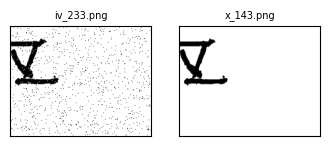

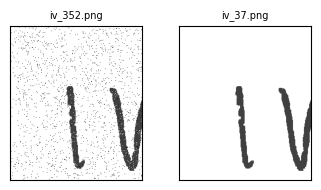

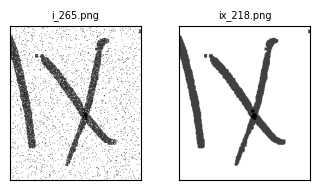

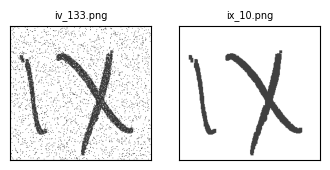

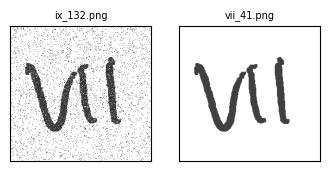

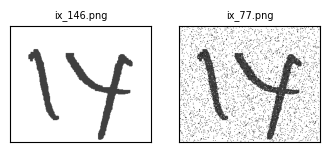

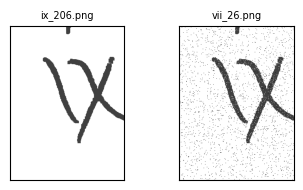

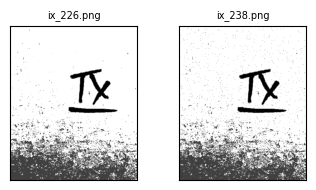

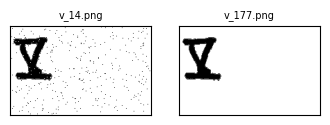

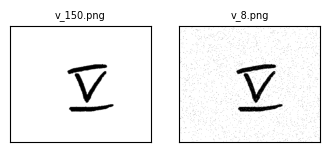

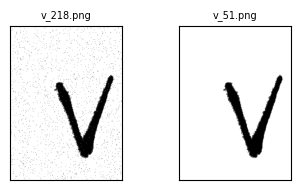

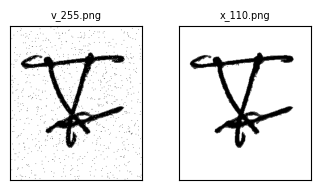

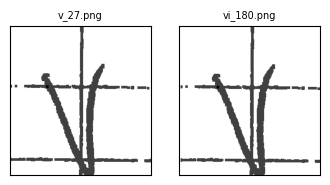

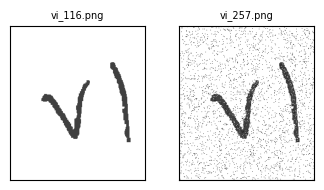

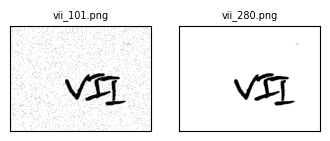

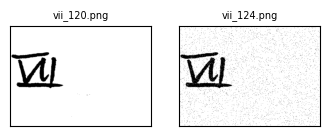

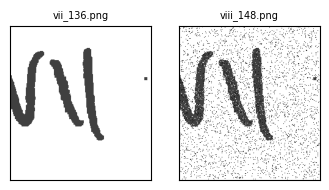

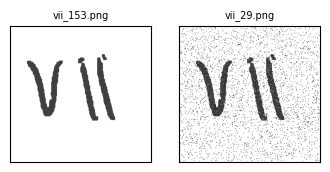

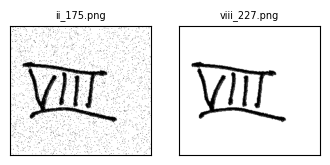

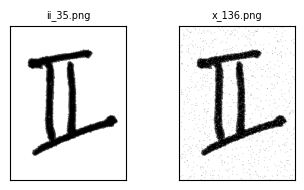

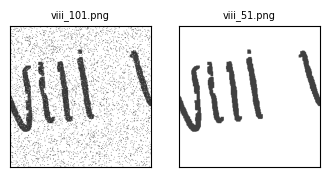

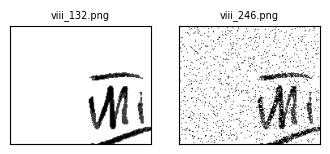

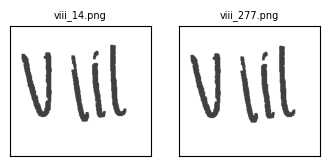

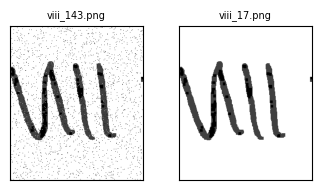

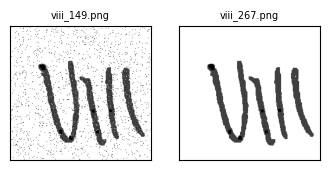

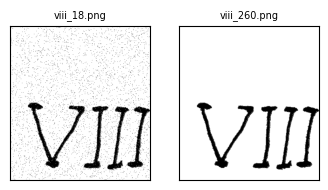

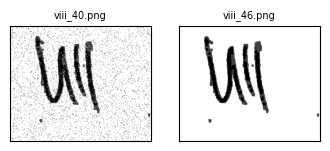

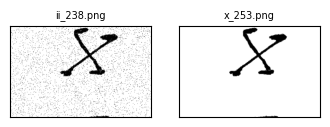

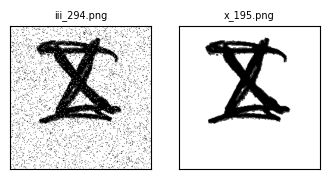

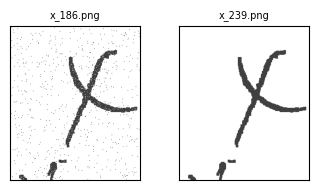

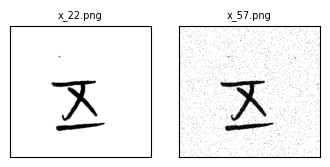

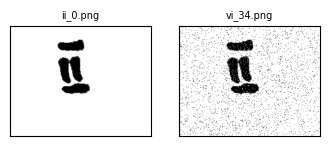

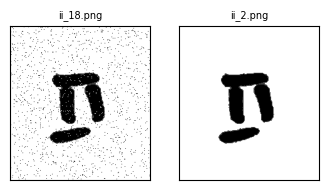

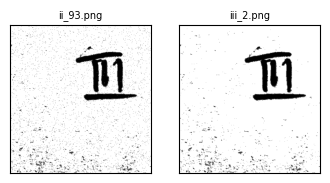

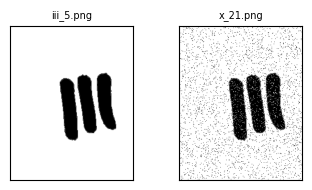

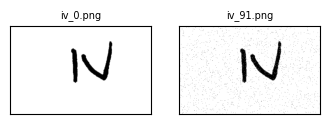

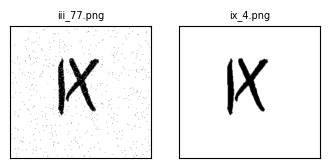

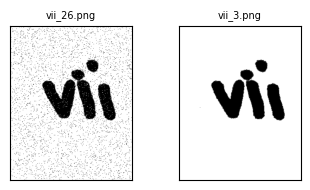

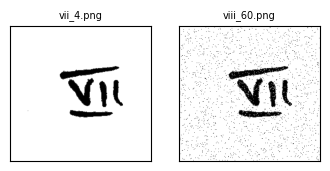

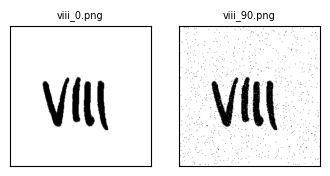

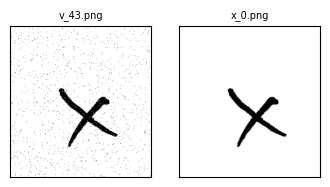

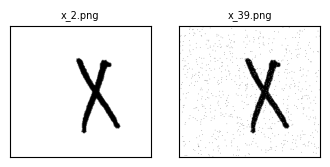

In [ ]:
for set in imagelab.info['near_duplicates']['sets']:
  imagelab.visualize(image_files=set)

In [ ]:
# Move images with mislabel issues to the correct directory
import shutil

# iii_85
img_move_1 = imagelab.info['near_duplicates']['sets'][0][1]
shutil.move(img_move_1, '/content/training_data/train/i/iii_85.png')

# i_125
img_move_2 = imagelab.info['near_duplicates']['sets'][1][0]
shutil.move(img_move_2, '/content/training_data/train/iii/i_125.png')

# viii_105
img_move_3 = imagelab.info['near_duplicates']['sets'][6][1]
shutil.move(img_move_3, '/content/training_data/train/v/i_105.png')

# ii_34
img_move_4 = imagelab.info['near_duplicates']['sets'][11][0]
shutil.move(img_move_4, '/content/training_data/train/v/ii_34.png')

# iii_0
img_move_5 = imagelab.info['near_duplicates']['sets'][12][0]
shutil.move(img_move_5, '/content/training_data/train/vi/iii_0.png')

# ix_151
img_move_6 = imagelab.info['near_duplicates']['sets'][13][1]
shutil.move(img_move_6, '/content/training_data/train/iii/ix_151.png')

# iv_233
img_move_7 = imagelab.info['near_duplicates']['sets'][15][0]
shutil.move(img_move_7, '/content/training_data/train/x/iv_233.png')

# ix_132
img_move_8 = imagelab.info['near_duplicates']['sets'][19][0]
shutil.move(img_move_8, '/content/training_data/train/vii/ix_132.png')

# vii_26
img_move_9 = imagelab.info['near_duplicates']['sets'][21][1]
shutil.move(img_move_9, '/content/training_data/train/ix/vii_26.png')

# viii_148
img_move_10 = imagelab.info['near_duplicates']['sets'][31][1]
shutil.move(img_move_10, '/content/training_data/train/vii/viii_148.png')

# x_136
img_move_11 = imagelab.info['near_duplicates']['sets'][34][1]
shutil.move(img_move_11, '/content/training_data/train/ii/x_136.png')

# ii_93
img_move_12 = imagelab.info['near_duplicates']['sets'][48][0]
shutil.move(img_move_12, '/content/training_data/train/iii/ii_93.png')

# viii_60
img_move_13 = imagelab.info['near_duplicates']['sets'][53][1]
shutil.move(img_move_13, '/content/training_data/train/vii/viii_60.png')

'/content/training_data/train/vii/viii_60.png'

## exact duplicates

In [ ]:
imagelab.info['exact_duplicates']['num_sets']

49

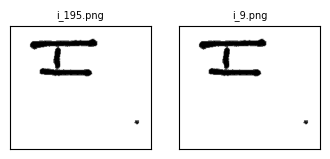

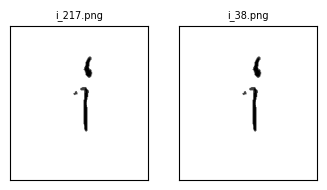

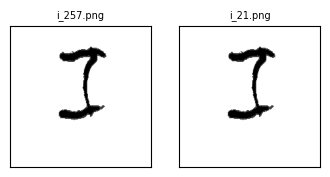

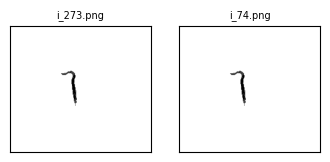

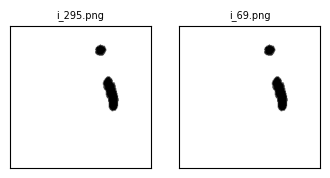

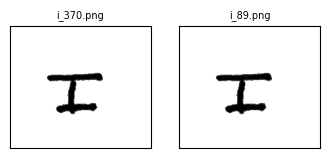

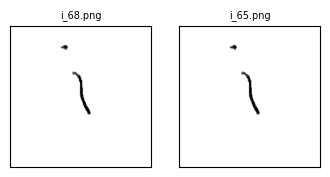

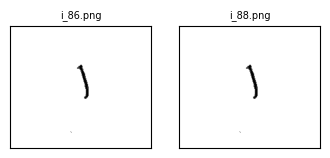

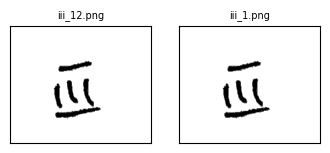

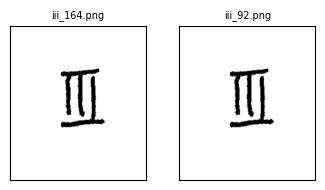

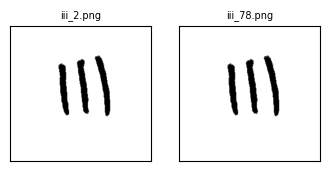

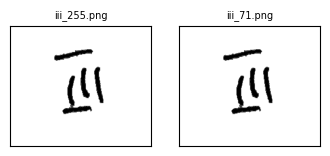

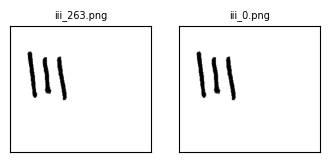

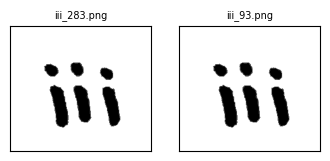

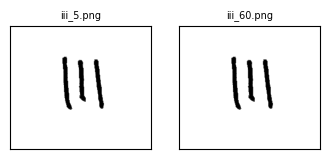

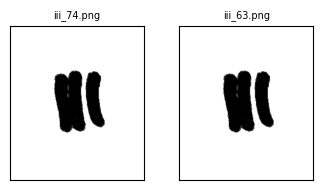

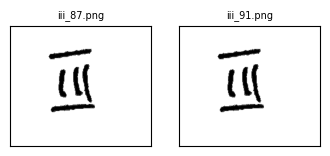

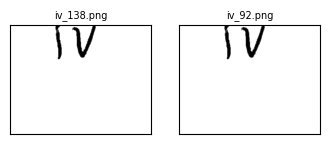

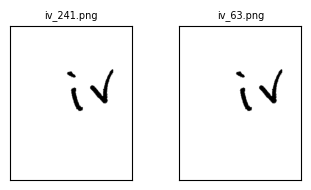

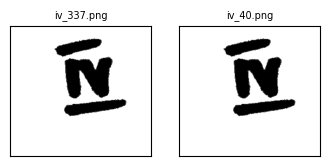

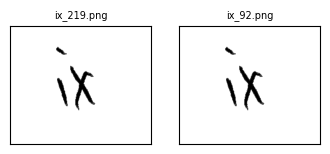

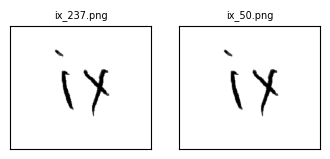

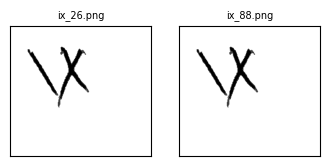

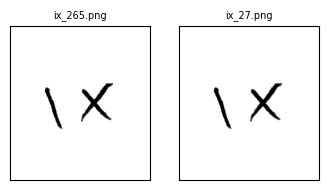

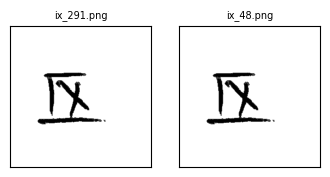

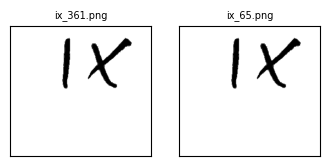

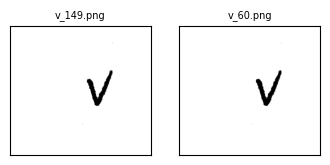

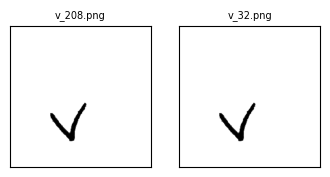

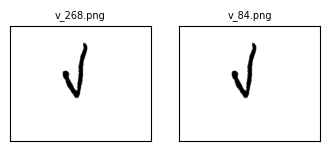

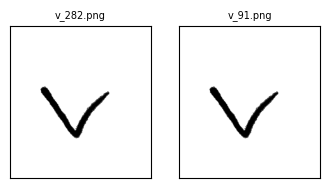

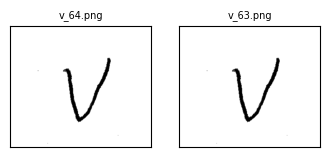

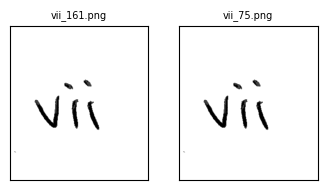

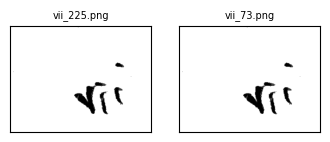

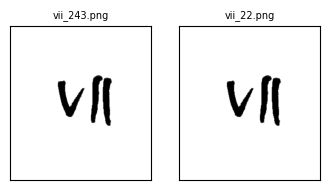

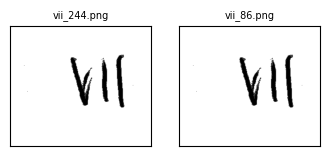

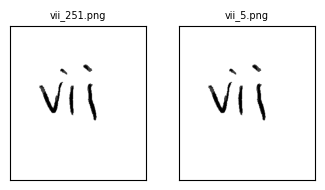

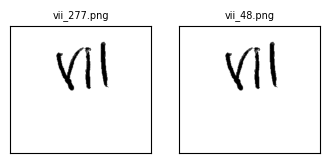

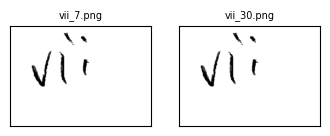

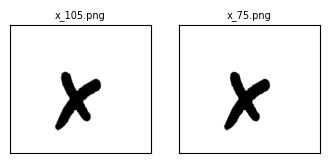

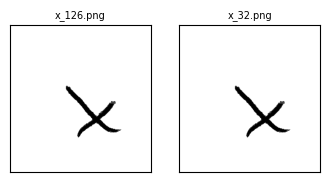

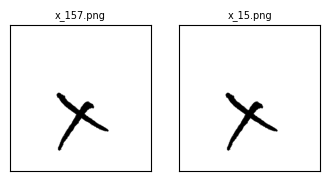

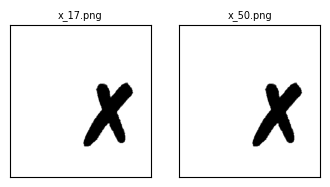

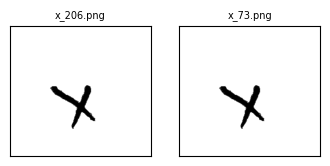

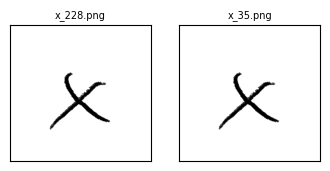

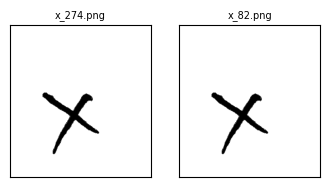

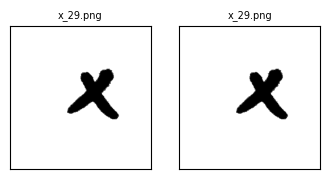

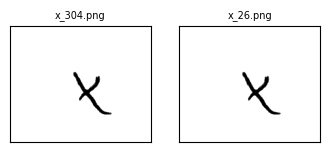

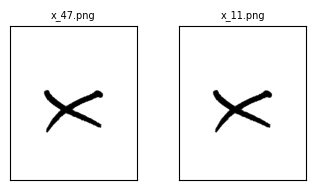

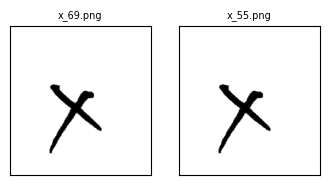

In [ ]:
for set in imagelab.info['exact_duplicates']['sets']:
  imagelab.visualize(image_files=set)

In [ ]:
# Delete images with exact duplicates issues
drop_idx = []

for set in imagelab.info['exact_duplicates']['sets']:
  drop_idx.append(set[0])

for file_path in drop_idx:
  if os.path.isfile(file_path):  # Check if file exists
    os.remove(file_path)  # Delete the file
    print(f"Deleted: {file_path}")
  else:
    print(f"File not found: {file_path}")

Deleted: /content/training_data/train/i/i_195.png
Deleted: /content/training_data/train/i/i_217.png
Deleted: /content/training_data/train/i/i_257.png
Deleted: /content/training_data/train/i/i_273.png
Deleted: /content/training_data/train/i/i_295.png
Deleted: /content/training_data/train/i/i_370.png
Deleted: /content/training_data/train/i/i_68.png
Deleted: /content/training_data/train/i/i_86.png
Deleted: /content/training_data/train/iii/iii_12.png
Deleted: /content/training_data/train/iii/iii_164.png
Deleted: /content/training_data/train/iii/iii_2.png
Deleted: /content/training_data/train/iii/iii_255.png
Deleted: /content/training_data/train/iii/iii_263.png
Deleted: /content/training_data/train/iii/iii_283.png
Deleted: /content/training_data/train/iii/iii_5.png
Deleted: /content/training_data/train/iii/iii_74.png
Deleted: /content/training_data/train/iii/iii_87.png
Deleted: /content/training_data/train/iv/iv_138.png
Deleted: /content/training_data/train/iv/iv_241.png
Deleted: /content/t

## odd size

In [ ]:
# Delete images with odd size issues
odd_size_img = imagelab.issues[imagelab.issues["is_odd_size_issue"] == True].index.to_list()

for file_path in odd_size_img:
  if os.path.isfile(file_path):  # Check if file exists
    os.remove(file_path)  # Delete the file
    print(f"Deleted: {file_path}")
  else:
    print(f"File not found: {file_path}")

Deleted: /content/training_data/train/i/i_16.png
Deleted: /content/training_data/train/i/i_165.png
Deleted: /content/training_data/train/i/i_172.png
Deleted: /content/training_data/train/i/i_173.png
Deleted: /content/training_data/train/i/i_181.png
Deleted: /content/training_data/train/i/i_193.png
Deleted: /content/training_data/train/i/i_203.png
Deleted: /content/training_data/train/i/i_219.png
Deleted: /content/training_data/train/i/i_23.png
Deleted: /content/training_data/train/i/i_261.png
Deleted: /content/training_data/train/i/i_283.png
Deleted: /content/training_data/train/i/i_293.png
Deleted: /content/training_data/train/i/i_294.png
Deleted: /content/training_data/train/i/i_299.png
Deleted: /content/training_data/train/i/i_320.png
Deleted: /content/training_data/train/i/i_343.png
Deleted: /content/training_data/train/i/i_43.png
Deleted: /content/training_data/train/i/i_56.png
Deleted: /content/training_data/train/i/vi_309.png
Deleted: /content/training_data/train/ii/ii_253.png
D

# Cleanlab

In [ ]:
imagelab = Imagelab(data_path=dataset_path)

# Get the filepaths
filepaths = imagelab._dataset._filepaths

# Get labels
labels = [os.path.basename(os.path.dirname(path)) for path in filepaths]

Reading images from /content/training_data


In [ ]:
images = []
for path in filepaths:
    img = Image.open(path).convert('RGB')
    img = img.resize((32, 32))
    images.append(np.array(img))

In [ ]:
# Label mapping
label_mapping = {
    "i": 0,
    "ii": 1,
    "iii": 2,
    "iv": 3,
    "v": 4,
    "vi": 5,
    "vii": 6,
    "viii": 7,
    "ix": 8,
    "x": 9,
}

labels = [label_mapping[label] for label in labels]

In [ ]:
def build_model():
    DefaultConv2D = partial(
    tf.keras.layers.Conv2D,
    kernel_size=3,
    padding="same",
    activation="relu",
    kernel_initializer="he_normal"
    )
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(32, 32, 3)),  # Define the input shape here
        tf.keras.layers.Rescaling(1./255),
        DefaultConv2D(filters=32),
        DefaultConv2D(filters=32),
        tf.keras.layers.MaxPool2D(),
        DefaultConv2D(filters=64),
        DefaultConv2D(filters=64),
        tf.keras.layers.MaxPool2D(),
        DefaultConv2D(filters=128),
        DefaultConv2D(filters=128),
        tf.keras.layers.MaxPool2D(),
        DefaultConv2D(filters=256),
        DefaultConv2D(filters=256),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Flatten(),
        # tf.keras.layers.Dense(units=64, activation="relu", kernel_initializer="he_normal"),
        # tf.keras.layers.Dense(units=32, activation="relu", kernel_initializer="he_normal"),
        tf.keras.layers.Dense(units=10, activation="softmax")
    ])
    model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001),
        metrics=["accuracy"])
    return model

In [ ]:
from sklearn.model_selection import cross_val_predict

clf = KerasClassifier(
    model=build_model,
    epochs=30,
    batch_size=8
)

In [ ]:
num_crossval_folds = 10
pred_probs = cross_val_predict(
    clf,
    images,
    labels,
    cv=num_crossval_folds,
    method="predict_proba",
)

Epoch 1/30
470/470 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.1534 - loss: 2.3050
Epoch 2/30
470/470 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5678 - loss: 1.3279
Epoch 3/30
470/470 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7851 - loss: 0.8233
Epoch 4/30
470/470 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8299 - loss: 0.6355
Epoch 5/30
470/470 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8517 - loss: 0.5411
Epoch 6/30
470/470 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8776 - loss: 0.4279
Epoch 7/30
470/470 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9002 - loss: 0.3347
Epoch 8/30
470/470 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9024 - loss: 0.3132
Epoch 9/30
470/470 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9175 - loss: 0.2636
Epoch 10/30
470/470 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9378 - loss: 0.2099
Epoch 11/30
470/470 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9406 - loss: 0.1978
Epoch 12/30
470/470 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/ste

In [ ]:
predicted_labels = pred_probs.argmax(axis=1)
acc = accuracy_score(labels, predicted_labels)
print(f"Cross-validated estimate of accuracy on held-out data: {acc}")

Cross-validated estimate of accuracy on held-out data: 0.7867241792475438


In [ ]:
ranked_label_issues = find_label_issues(
    labels,
    pred_probs,
    return_indices_ranked_by="self_confidence",
)

print(f"Cleanlab found {len(ranked_label_issues)} label issues.")

Cleanlab found 674 label issues.


In [ ]:
reverse_label_mapping = {value: key for key, value in label_mapping.items()}

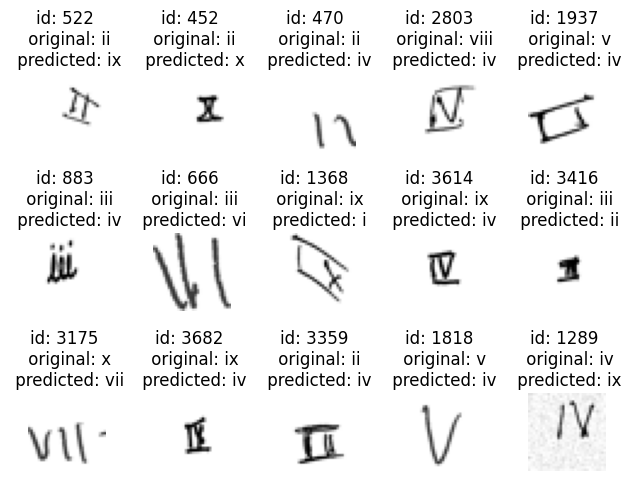

In [ ]:
plot_examples(ranked_label_issues[165:180], 3, 5)

In [ ]:
# Manually examine the former 180 images
# No label issue images
no_label_issue_id = [3032, 1246, 1839, 2580, 601, 2042, 1381, 220, 408, 2927, 640, 2719, 1302, 1769, 4076,
            1935, 1748, 3788, 432, 383, 41, 463, 3203, 441, 400, 2622, 2687, 3803, 2132, 2535, 714, 1659]

# Predicted wrong, fix manually
fix_manual = [139, 130, 456, 2967, 1937, 2809, 2340]

# id: 139
labels[139] = 5

# id:130
labels[130] = 1

# id: 456
labels[456] = 3

# id: 2967
labels[2967] = 1

# id: 1937
labels[1937] = 1

# id: 2809
labels[2809] = 3

# id: 2340
labels[2340] = 2

In [ ]:
# Automatically fix the mislabel issue by cleanlab
fix_automatic = ranked_label_issues[:180][~np.isin(ranked_label_issues[:180], no_label_issue_id) | ~np.isin(ranked_label_issues[:180], fix_manual)]

for id in fix_automatic:
    labels[id] = predicted_labels[id]

In [ ]:
labels = [reverse_label_mapping[label] for label in labels]

In [ ]:
for i, path in enumerate(filepaths):
  subfolder = os.path.basename(os.path.dirname(os.path.dirname(path)))
  label_folder = labels[i]
  file_name = os.path.basename(path)

  target_dir = f'/content/training_data/{subfolder}/{label_folder}'

  shutil.move(path, f'{target_dir}/{file_name}')

# Data Augmentation

In [ ]:
# Batch size set to 1
seed = 2024
train_dataset = image_dataset_from_directory(
    '/content/training_data/train',
    image_size=(32, 32),
    shuffle=True,
    batch_size=1,
    seed=seed)
validation_dataset = image_dataset_from_directory(
    '/content/training_data/val',
    image_size=(32, 32),
    shuffle=False,
    batch_size=1)

Found 3227 files belonging to 10 classes.
Found 946 files belonging to 10 classes.


In [ ]:
dataset = train_dataset.concatenate(validation_dataset)
len(dataset)

4173

In [ ]:
import os
import random
from tqdm import tqdm
from functools import partial
import tensorflow as tf
import numpy as np
import albumentations as A
from PIL import Image, ImageEnhance

# Parameters
batch_size = 32
image_size = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE
total_target_train = 6028
val_target = 1800

# Function to calculate augmentation requirements
def calculate_augmentation(target_total, current_total, num_classes):
    return max(0, (target_total - current_total) // num_classes)

# Custom augmentation based on labels
def custom_augmentation(image, label):
    if label in ['i', 'ii', 'iii', 'x']:  # Horizontal flip and vertical flip
        transforms = A.Compose([
            A.HorizontalFlip(),
            A.VerticalFlip(),
            A.Rotate(limit=30), # rotate 30 degrees
            A.ElasticTransform(),
            A.MedianBlur(),
            A.GaussNoise(),
            A.CLAHE(),
            A.RandomScale(),
            A.RandomBrightnessContrast()
        ])
    elif label in ['ix']:  # Only vertical flip
        transforms = A.Compose([
            A.VerticalFlip(),
            A.Rotate(limit=30), # rotate 30 degrees
            A.ElasticTransform(),
            A.MedianBlur(),
            A.GaussNoise(),
            A.CLAHE(),
            A.RandomScale(),
            A.RandomBrightnessContrast()
        ])
    elif label == 'v':  # Only horizontal flip
        transforms = A.Compose([
            A.HorizontalFlip(),
            A.Rotate(limit=30), # rotate 30 degrees
            A.ElasticTransform(),
            A.MedianBlur(),
            A.GaussNoise(),
            A.CLAHE(),
            A.RandomScale(),
            A.RandomBrightnessContrast()
        ])
    else:
        transforms = A.Compose([
            A.Rotate(limit=30), # rotate 30 degrees
            A.ElasticTransform(),
            A.MedianBlur(),
            A.GaussNoise(),
            A.CLAHE(),
            A.RandomScale(),
            A.RandomBrightnessContrast()
        ])
    return transforms

# File-based augmentations

def augment_image(image, label):
    transforms = custom_augmentation(image, label)
    image = np.array(image)
    augmented = transforms(image=image)
    return Image.fromarray(augmented["image"])

def perform_augmentation(base_dir, target_total, scale_factor=1.0):
    for label in os.listdir(base_dir):
        label_path = os.path.join(base_dir, label)
        if os.path.isdir(label_path):
            current_images = [f for f in os.listdir(label_path) if f.endswith('.png') or f.endswith('.jpg')]
            current_total = len(current_images)
            num_to_augment = int(calculate_augmentation(target_total, current_total, len(os.listdir(base_dir))) * scale_factor)
            for i in tqdm(range(num_to_augment), desc=f"Augmenting {label}"):
                img_name = random.choice(current_images)
                img_path = os.path.join(label_path, img_name)
                with Image.open(img_path) as img:
                    augmented_img = augment_image(img, label)
                    new_img_name = f"{os.path.splitext(img_name)[0]}_aug_{i}.png"
                    augmented_img.save(os.path.join(label_path, new_img_name))

# Paths
train_dir = user_data + '/train'
val_dir = user_data + '/val'

# Execute file-level augmentation
perform_augmentation(train_dir, total_target_train, scale_factor=1.0)
perform_augmentation(val_dir, val_target, scale_factor=1.0)

# Integrate tf.data pipeline for additional runtime augmentations
# Assuming `train_ds` and `val_ds` are created using `tf.data.Dataset`
train_ds = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                 image_size=(image_size, image_size),
                                 batch_size=batch_size)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(val_dir,
                                 image_size=(image_size, image_size),
                                 batch_size=batch_size)

Augmenting iv: 100%|██████████| 154/154 [00:02<00:00, 58.37it/s]


Found 8409 files belonging to 10 classes.
Found 2491 files belonging to 10 classes.


# Rules

- Submission must have less than 12,000 images combined in training and validation

**Submissions will be evaluated according to two categories:**
1. **Best Performance Overall**
2. **Most Innovative**

# Getting started


The dataset contains ~4400 images of handwritten roman numerals 1-10. **Your task is to optimize model performance by improving the dataset and making training and validation splits.**

You can try fixing incorrect labels, adding data for side case tuning, apply data augmentation techniques, or use any other method to improve the data. You may also find it helpful to take a look at the training script to get a better sense of the model below (these are held fixed). The script will resize all images to `(32, 32)` and run them through a cut off version of ResNet50.

In [ ]:
### DO NOT MODIFY BELOW THIS LINE, THIS IS THE FIXED MODEL ###
tf.keras.backend.clear_session()
batch_size = 8
tf.random.set_seed(2024)

train = tf.keras.preprocessing.image_dataset_from_directory(
        user_data + '/train',
        labels="inferred",
        label_mode="categorical",
        class_names=["i", "ii", "iii", "iv", "v", "vi", "vii", "viii", "ix", "x"],
        shuffle=True,
        seed=123,
        batch_size=batch_size,
        image_size=(32, 32),
    )

valid = tf.keras.preprocessing.image_dataset_from_directory(
        user_data + '/val',
        labels="inferred",
        label_mode="categorical",
        class_names=["i", "ii", "iii", "iv", "v", "vi", "vii", "viii", "ix", "x"],
        shuffle=True,
        seed=123,
        batch_size=batch_size,
        image_size=(32, 32),
)

total_length = ((train.cardinality() + valid.cardinality()) * batch_size).numpy()

if total_length > 12_000:
    print(f"Dataset size larger than 12,000. Got {total_length} examples")
    sys.exit()

test = tf.keras.preprocessing.image_dataset_from_directory(
        test_data,
        labels="inferred",
        label_mode="categorical",
        class_names=["i", "ii", "iii", "iv", "v", "vi", "vii", "viii", "ix", "x"],
        shuffle=False,
        seed=123,
        batch_size=batch_size,
        image_size=(32, 32),
)

# Initialize the base model using KerasCV's ResNet50
backbone = keras_cv.models.ResNet50Backbone.from_preset(
    input_shape=(32, 32, 3),
    preset = "resnet50_imagenet",
    load_weights=False,
)

# Create a new model that outputs the desired intermediate layer
base_model = tf.keras.Model(
    inputs=backbone.inputs,
    outputs=backbone.get_layer("v2_stack_0_block3_out").output
)

# Define the input tensor
inputs = tf.keras.Input(shape=(32, 32, 3))

# Pass the preprocessed input through the base model
x = base_model(inputs)

# Add global average pooling
x = tf.keras.layers.GlobalAveragePooling2D()(x)

# Add a dense layer for classification (assuming 10 classes)
x = tf.keras.layers.Dense(10)(x)

# Define the final model
model = tf.keras.Model(inputs, x)

# Compile the model with appropriate optimizer, loss, and metrics
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

# Display the model's architecture
model.summary()

loss_0, acc_0 = model.evaluate(valid)
print(f"loss {loss_0}, acc {acc_0}")

checkpoint = tf.keras.callbacks.ModelCheckpoint(
        "best_model.weights.h5",
        monitor="val_accuracy",
        mode="max",
        save_best_only=True,
        save_weights_only=True,
)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=10, verbose=1, min_lr=1e-7)

history = model.fit(
        train,
        validation_data=valid,
        epochs=75,
        callbacks=[checkpoint, lr_scheduler],
)

model.load_weights("best_model.weights.h5")

loss, acc = model.evaluate(valid)
print(f"final loss {loss}, final acc {acc}")

test_loss, test_acc = model.evaluate(test)
print(f"test loss {test_loss}, test acc {test_acc}")

### DO NOT MODIFY ABOVE THIS LINE, THIS IS THE FIXED MODEL ###

Found 8409 files belonging to 10 classes.
Found 2491 files belonging to 10 classes.
Found 52 files belonging to 10 classes.


100%|██████████| 777/777 [00:00<00:00, 1.09MB/s]


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional (Functional)              │ (None, 8, 8, 256)           │         228,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 230,858 (901.79 KB)

 Trainable params: 227,914 (890.29 KB)

 Non-trainable params: 2,944 (11.50 KB)

312/312 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.0985 - loss: 2.3179
loss 2.317533254623413, acc 0.09915696829557419
Epoch 1/75
1052/1052 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.2480 - loss: 2.1817 - val_accuracy: 0.3296 - val_loss: 1.8632 - learning_rate: 1.0000e-04
Epoch 2/75
1052/1052 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5079 - loss: 1.4441 - val_accuracy: 0.5243 - val_loss: 1.4532 - learning_rate: 1.0000e-04
Epoch 3/75
1052/1052 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6439 - loss: 1.1215 - val_accuracy: 0.6070 - val_loss: 1.1641 - learning_rate: 1.0000e-04
Epoch 4/75
1052/1052 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7091 - loss: 0.9433 - val_accuracy: 0.6255 - val_loss: 1.1209 - learning_rate: 1.0000e-04
Epoch 5/75
1052/1052 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7545 - loss: 0.8070 - val_accuracy: 0.6696 - val_loss: 1.0102 - learning_rate: 1.0000e-04
Epoch 6/75
1052/1052 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7836 - loss: 0.697

# Make your submission

Remember that the evaluation metric is Macro F1 score, you may want to also evaluate the above results using the Macro F1 score before submission.

In [ ]:
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory+"testing_data",
    shuffle = False,
    image_size=(32, 32),
    batch_size=1)

prob = model.predict(test_dataset)
predictions = []
for i in range(0, prob.shape[0]):
    predictions.append(np.argmax(prob[i,:])+1)

Found 500 files belonging to 1 classes.
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


In [ ]:
import pandas as pd

paths = test_dataset.file_paths

Ids = []
for x in paths:
    Ids.append(x.split("/")[-1])

df = pd.DataFrame()
df["Id"] = Ids
df["Predicted"] = predictions
df.to_csv("submission.csv", index=False)

# Save data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!cp -r /content/training_data /content/drive/MyDrive/training_data

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!zip -r /content/training_data.zip /content/training_data

串流輸出內容已截斷至最後 5000 行。
  adding: content/training_data/train/x/x_161_aug_321.png (deflated 2%)
  adding: content/training_data/train/x/x_238_aug_463.png (deflated 4%)
  adding: content/training_data/train/x/ii_193.png (deflated 12%)
  adding: content/training_data/train/x/x_235.png (deflated 3%)
  adding: content/training_data/train/x/x_276_aug_517.png (deflated 0%)
  adding: content/training_data/train/x/x_208.png (deflated 7%)
  adding: content/training_data/train/x/x_62_aug_476.png (deflated 2%)
  adding: content/training_data/train/x/x_83_aug_324.png (stored 0%)
  adding: content/training_data/train/x/x_203.png (deflated 1%)
  adding: content/training_data/train/x/x_107_aug_189.png (deflated 0%)
  adding: content/training_data/train/x/x_302_aug_265.png (stored 0%)
  adding: content/training_data/train/x/x_140_aug_43.png (deflated 12%)
  adding: content/training_data/train/x/x_303_aug_77.png (deflated 20%)
  adding: content/training_data/train/x/x_102.png (deflated 1%)
  adding: conte